<a href="https://colab.research.google.com/github/samirsalman/Pneumonia-RX-Classifier/blob/main/PneumoniaDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detector

## Normal, Virus or Bacterial Pneumonia Detector
In this project I create a Pneumonia RX Classifier. The dataset used is aviable at this URL:

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Categories of classification are:
- NORMAL -> No pneumonia RX
- PNEUMONIA_VIRUS -> RX with Virus Pneumonia
- PNEUMONIA_BACTERIA -> RX with Bacteria Pneumonia


# Install Kaggle plugin

We install kaggle plugin in order to download data with Kaggle APIs. 

For more info you can read this:

https://www.kaggle.com/general/74235

In [1]:
 ! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# download dataset from kaggle

! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:31<00:00, 125MB/s]
100% 2.29G/2.29G [00:31<00:00, 78.9MB/s]


In [ ]:
# unzip data

! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/PNEUMONIA/person1524_virus_2658.jpeg  
  inflating: chest_xray/chest_xray/train/PNEUMONIA/person1525_bacteria_3985.jpeg  
  inflating: chest_xray/chest_xray/train/PNEUMONIA/person1525_virus_2659.jpeg  
  inflating: chest_xray/chest_xray/train/PNEUMONIA/person1526_bacteria_3986.jpeg  
  inflating: chest_xray/chest_xray/train/PNEUMONIA/person1526_virus_2660.jpeg  
  inflating: chest_xray/chest_xray/train/PNEUMONIA/person1527_bacteria_3988.jpeg  
  inflating: chest_xray/chest_xray/train/PNEUMONIA/person1527_bacteria_3989.jpeg  
  inflating: chest_xray/chest_xray/train/PNEUMONIA/person1527_bacteria_3990.jpeg  
  inflating: chest_xray/chest_xray/train/PNEUMONIA/person1527_virus_2661.jpeg  
  inflating: chest_xray/chest_xray/train/PNEUMONIA/person1528_bacteria_3991.jpeg  
  inflating: chest_xray/chest_xray/train/PNEUMONIA/person1528_bacteria_3996.jpeg  
  inflating: chest_xray/chest_xray/train/PNEUMON

In [ ]:
#import statements 

import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


# Define HyperParameters like TRAINING flag and image HEIGHT and WIDTH

In [ ]:
TRAINING = False

In [ ]:
IMG_HEIGHT = 316
IMG_WIDTH = 316

# Create Dataset from Images
From images to dataset with image vectors and labels 

In [ ]:
!pip install Pillow
from PIL import Image

def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]

    for subdir in os.listdir(os.path.join(img_folder)):
        for file in os.listdir(os.path.join(img_folder,subdir)):
          image_path= os.path.join(img_folder,  subdir, file)
          image= Image.open(image_path).convert('RGB')
          image = image.resize((IMG_HEIGHT, IMG_WIDTH))
          image=np.array(image)
          image = image.astype('float32')
          image.reshape(-1,IMG_HEIGHT,IMG_WIDTH,3)
          image /= 255 

          img_data_array.append(image)
          if subdir=="PNEUMONIA":
            pneumonia_class = f'PNEUMONIA_{file.split("_")[1].upper()}'
            class_name.append(pneumonia_class)
          else:
            class_name.append(subdir)

    return img_data_array, class_name



```
annotation_df = pd.read_csv("./train.csv")
annotation_df.head()
```



In [ ]:
#Create dataset from imgs data

if TRAINING:
  img_data, class_name  = create_dataset("./chest_xray/train/")
else:
  img_data_train, class_name_train  = create_dataset("./chest_xray/train/")
  img_data_test, class_name_test  = create_dataset("./chest_xray/test/")

#validation set
img_data_val, class_name_val  = create_dataset("./chest_xray/val/")


In [ ]:
# get labels in dataset

if TRAINING: 
  np.unique(class_name)
else:
  np.unique(class_name_train)
  

In [ ]:
# convert string label to integer label

def from_literal_label_to_integer(data, classes):
  labels = []
  for el in data:
      labels.append(classes[el])
  return labels      


In [ ]:
# labels
classes = {'NORMAL':0, "PNEUMONIA_BACTERIA":1, "PNEUMONIA_VIRUS":2}

# convert string label to integer label
if TRAINING:
  class_name = from_literal_label_to_integer(class_name, classes)
else:
  class_name_test = from_literal_label_to_integer(class_name_test, classes)
  class_name_train = from_literal_label_to_integer(class_name_train, classes)

class_name_val = from_literal_label_to_integer(class_name_val, classes)

In [ ]:
if TRAINING:
  #create a bar chart with labels distribution
  values = np.unique(class_name,return_counts=True)[1]
  print(values)
  plt.bar(x = np.unique(class_name),height=values,)




```
import pickle

filename = 'img_data'
outfile = open(filename,'wb')
pickle.dump(img_data,outfile)
outfile.close()
```



In [ ]:
from sklearn.model_selection import train_test_split

if TRAINING:
  # split training data in train and test
  x_train, x_test, y_train, y_test = train_test_split(img_data, class_name, test_size=0.2, random_state=42)
else:
  # load training and test data if TEST step
  x_train, y_train = img_data_train, class_name_train
  
  x_test, y_test = img_data_test, class_name_test

  x_val, y_val = img_data_val, class_name_val


# Create CNN model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D 
 
def create_model(num_classes, width, height, nb_filters=32, kernel_size =(3,3), pool_size =(2,2)):
 
 
  input_shape = (height, width, 3)
  model = Sequential()
 
  model.add(Conv2D(nb_filters, kernel_size,
                  padding='valid',
                  input_shape=input_shape))
 
  model.add(Activation('relu'))
 
  model.add(Conv2D(nb_filters, kernel_size))
 
  model.add(Activation('relu'))
  
  model.add(Conv2D(nb_filters, kernel_size))
  model.add(Activation('relu'))
 
  model.add(MaxPooling2D(pool_size=pool_size))
 
  model.add(Dropout(0.5))
 
  model.add(Flatten())
 
  model.add(Dense(units=528))
 
  model.add(Activation('relu'))
 
  model.add(Dropout(0.20))
 
  model.add(Dense(units=num_classes))
 
  model.add(Activation('softmax'))
 
  return model

In [ ]:
model = None
model = create_model(3,IMG_HEIGHT, IMG_WIDTH)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 314, 314, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 314, 314, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 312, 312, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 312, 312, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 310, 310, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 310, 310, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 155, 155, 32)      0

# Training Step

In [ ]:
# define number of epochs
EPOCHS=6
 
history = model.fit(
  x=np.array(x_train, np.float32),
  y=np.array(y_train, np.float32),
  validation_data=(np.array(x_val, np.float32),np.array(y_val, np.float32)),
  validation_steps = 8,
  batch_size=32,
  epochs=EPOCHS,
  verbose=1
)

# Test the system

In [ ]:
results = model.evaluate(np.array(x_test, np.float32), np.array(y_test, np.float32), batch_size=128)

20/20 [==============================] - 0s 20ms/step - loss: 2.4568 - accuracy: 0.6234


# Study Errors

In this section we are going to study all model errors.
get_prediction function allow you to see a specific image with its prediction and its true label.

In [ ]:
# get predictions over test set
preds = model.predict(np.array(x_test, np.float32))

In [ ]:
!pip install Pillow
from PIL import Image


In [ ]:
from numpy import asarray

# function that allow us to see predicted image with true label
def get_prediction(index,classes):
  data = asarray(x_test[index])

  data_image = Image.fromarray((data * 255).astype(np.uint8))
  data_image.resize((400,400))
  data_image.show()

  imshow(data_image)
  res = np.argmax(preds[index])
  print(f'Prediction: {list(classes.keys())[res]}')  
  print(f'True label: {list(classes.keys())[y_test[index]]}')



In [ ]:
# extract all errors in test-set
def get_errors(preds,classes):
  errors = []
  for el in range(len(preds)):
    res = np.argmax(preds[el])
    if res != y_test[el]:
      errors.append(el)
  return errors


Prediction: PNEUMONIA_VIRUS
True label: PNEUMONIA_BACTERIA


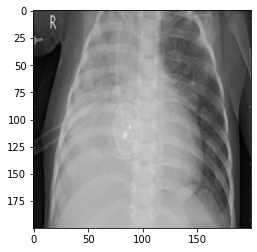

In [ ]:
errors = get_errors(preds,classes)
get_prediction(errors[2],classes)

#Prediction of External Image

You can upload a new image and classify it with predict_external_image function

In [ ]:
# predict external image

def predict_external_image(img_path):
  image= Image.open(img_path).convert('RGB')
  image = image.resize((IMG_HEIGHT, IMG_WIDTH))
  image=np.array(image)
  image = image.astype('float32')
  image /= 255

  # in order to predict it
  image = np.expand_dims(image, axis = 0)
 
  # model prediction
  pred = model.predict(np.array(image, np.float32))

  #see image
  data_image = Image.open(img_path)
  data_image = data_image.resize((400,400))
  data_image.show()

  imshow(data_image)
  
  res = np.argmax(pred)
  print(f'Prediction: {list(classes.keys())[res]}')  


Prediction: PNEUMONIA_VIRUS


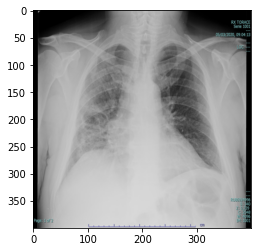

In [ ]:
predict_external_image("covid.jpeg")

# Use this function to Release RAM

In [ ]:
#release memory
from numba import cuda

cuda.select_device(0)
cuda.close()